# Crime Analysis using Big Data 
# Paul Carmody (W23056813) 26-Mar-2025
## 1.) Introduction

Using modern data analysis techniques on crime data can significantly benefit law enforcement efforts and urban planning, which improves general safety, resource allocation and crime prevention strategies [1]. In this report, we apply such techniques to evaluate several claims made in the 2018 documentary Ross Kemp and the Armed Police, which raised concerns about violent crime trends in the UK. Specifically, the programme suggested:

__1.	that burglaries were increasing;__

__2.	that Birmingham experienced more burglary incidents per capita than anywhere else in the UK and__

__3.	that firearm-related crimes were closely associated with drug offences.__


This report critically analyses these claims using a __big data approach__. It will leverage a large publicly available crime dataset – the UK Home Office’s street-level crime data containing roughly 19 million reported crime records with location and type– alongside supplementary data to evaluate each claim empirically [2],[3]. The data was taken from the official UK police download portal [4].

The technical workflow follows a __structured ETL pipeline__ (Extract, Transform, Load) built using __Azure Infrastructure-as-a-Service__ (IaaS) to efficiently handle and process large volumes of crime data [5]. __PySpark__ is then implemented to take advantage of distributed processing, ensuring scalability, while __Pandas__, __Matplotlib__ and __Seaborn__ facilitate exploratory data analysis (EDA) and visualisation [6].

The analysis methodology includes:

__•	Time-series analysis__ to examine burglary trends over time.

__•	Per capita rate calculations__ compare Birmingham’s burglary rates with other cities.

__•	Correlation and regression analysis__ to investigate the relationship between drug offences and firearm-related crime.

Findings are interpreted in the context of official crime statistics and existing academic literature to reach valid conclusions. This report aims to determine whether the documentary’s claims are supported by empirical evidence and illustrate how big data analytics can provide insights into crime trends, affirming or rejecting widely circulated narratives in relation to crime within the media.


## 2.) Component Selection and Data Pipeline Implementation
In order to best process large-scale UK crime data, __Apache Spark__ is used on __Azure IaaS__ for its ability to handle big data through distributed computing. 

This section outlines the tools and pipeline used for data extraction, cleaning and transformation.

In [1]:
# --------------------------
# Load Necessary Libraries
# --------------------------

# --------------------------
# PySpark Imports
# --------------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, year, month, to_date, sum as spark_sum, avg, desc, round,
    regexp_replace, rtrim, split, when
)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

# --------------------------
# Data Analysis & Visualisation
# --------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr, chi2_contingency
import statsmodels.api as sm
import warnings


# Pandas: Used for data manipulation and converting PySpark DataFrames to Pandas DataFrames for visualisations. [6]
# Seaborn: Used for creating plots and graphs to visualise crime trends. [6]
# Matplotlib: Used for creating plots and graphs to visualise crime trends. [6]
# SciPy (ttest_ind, pearsonr, chi2_contingency): Used for statistical tests such as t-tests, correlation, and chi-squared tests.
# Statsmodels (sm): Used for regression modelling and advanced statistical analysis.
# Warnings: Used to suppress unnecessary warnings in the output.


In [2]:
# --------------------------
# 1. Initialize SparkSession
# --------------------------
session = SparkSession.builder.appName("NUCrimeAnalysisPipeline").getOrCreate()

In [3]:
# --------------------------
# 2. Data Loading
# --------------------------

# Define dataset paths
# crime_data_path = "Sample_1pc_Data.csv"  # Used for testing to reduce strain on Azure resources
crime_data_path = "all_crimes21_hdr.txt.gz"
lsoa_data_path = "LSOA_pop_v2.csv"

# Load Crime Data
crimeDF = session.read.csv(crime_data_path, header=True, inferSchema=True)

# Load LSOA and Population Data
lsoaDF = session.read.csv(lsoa_data_path, header=True, inferSchema=True)

# --------------------------
# 2.1 Preview Raw Data (Before Cleaning)
# --------------------------
print("\n[Diagnostic] Sample of Crime Data:")
crimeDF.show(5, truncate=False)  # Display first 5 rows for inspection

print("\n[Diagnostic] Sample of LSOA Population Data:")
lsoaDF.show(5, truncate=False)  # Display first 5 rows to verify structure

# Display schema to check data types
print("\n[Diagnostic] Schema of Crime Data:")
crimeDF.printSchema()

print("\n[Diagnostic] Schema of LSOA Population Data:")
lsoaDF.printSchema()



[Diagnostic] Sample of Crime Data:
+--------+-------+------------------------------+------------------------------+---------+---------+--------------------------+---------+---------------------------------+---------------------+---------------------+-------+
|Crime ID|Month  |Reported by                   |Falls within                  |Longitude|Latitude |Location                  |LSOA code|LSOA name                        |Crime type           |Last outcome category|Context|
+--------+-------+------------------------------+------------------------------+---------+---------+--------------------------+---------+---------------------------------+---------------------+---------------------+-------+
|null    |2010-12|Avon and Somerset Constabulary|Avon and Somerset Constabulary|-0.8056  |51.819143|On or near Norfolk Terrace|E01017662|Aylesbury Vale 015C              |Other crime          |null                 |null   |
|null    |2010-12|Avon and Somerset Constabulary|Avon and Somerset C

## 2.1) Standardizing and Cleaning Data
 
Upon inspection, it was necessary to ensure the datasets were __standardised__ to ensure consistency. This included __renaming columns to lowercase__, __replacing spaces with underscores__ to improve readability and usability and __dropping unnecessary columns.__

In [4]:
# --------------------------
# Data Inspection & Cleaning
# --------------------------

# Standardise Column Names (Crime & Population Data)
crimeDF = crimeDF.toDF(*[c.lower().replace(" ", "_") for c in crimeDF.columns])
lsoaDF = lsoaDF.toDF(*[c.lower().replace(" ", "_") for c in lsoaDF.columns])

# Select Required Columns from LSOA Dataset
lsoaDF_clean = lsoaDF.select(
    col('geography_code').alias('lsoa_code'),
    col('geography').alias('lsoa_name'),
    col('variable:_all_usual_residents;_measures:_value').alias('population')  # Extract Population Data
)

# Apply City Extraction to Correct DataFrame
lsoaDF_clean = lsoaDF_clean.withColumn(
    "city",
    rtrim(regexp_replace(col("lsoa_name"), r"\s+\S+$", ""))  # Remove last word after the last space to get the LSAO name by itself
)

# Select necessary Columns from Crime Dataset
crimeDF_clean = crimeDF.select(
    'crime_id', 'month', 'reported_by', 'falls_within', 'lsoa_code', 'crime_type', 'last_outcome_category'
)

# 3) Data Extraction and Filtering

In [5]:
# --------------------------
# 1. Date Conversion & Validation
# --------------------------
# Convert the 'month' column to a proper date format and extract 'year' and 'month_num' for analysis
crimeDF_clean = crimeDF_clean.withColumn("month", to_date(col("month"), "yyyy-MM")) \
                             .withColumn("year", year(col("month"))) \
                             .withColumn("month_num", month(col("month")))

# Validate Date Conversion by displaying a sample of transformed values
print("\n[Diagnostic] Sample values after transformation:")
crimeDF_clean.select("month", "year", "month_num").show(5, truncate=False)


[Diagnostic] Sample values after transformation:
+----------+----+---------+
|month     |year|month_num|
+----------+----+---------+
|2010-12-01|2010|12       |
|2010-12-01|2010|12       |
|2010-12-01|2010|12       |
|2010-12-01|2010|12       |
|2010-12-01|2010|12       |
+----------+----+---------+
only showing top 5 rows



In [6]:
# --------------------------
# 2. Extract & Analyse Burglary Crimes
# --------------------------
# Filter crime dataset to retain only burglary incidents
burglaryDF = crimeDF_clean.filter(col("crime_type") == "Burglary")

In [7]:
# --------------------------
# 3. City-Level Burglary Analysis
# --------------------------
# Join burglary data with LSOA dataset to get city names and compute burglary counts per city
city_burglary_counts = burglaryDF.join(lsoaDF_clean, "lsoa_code") \
    .groupBy("city") \
    .agg(count("crime_id").alias("burglary_count"),
         spark_sum("population").alias("city_population"))

# Compute burglary rate per 1,000 residents for each city
city_burglary_rates_by_rate = city_burglary_counts.withColumn(
    "burglary_rate_per_1000", (col("burglary_count") / col("city_population")) * 1000
).orderBy(desc("burglary_rate_per_1000"))

city_burglary_rates_by_count = city_burglary_counts.withColumn(
    "burglary_rate_per_1000", (col("burglary_count") / col("city_population")) * 1000
).orderBy(desc("burglary_count"))

In [8]:
# --------------------------
# 4. Birmingham vs National Burglary Rates
# --------------------------
# Compute annual burglary rate for Birmingham and compare with the national average
birmingham_burglary_trend = burglaryDF.join(lsoaDF_clean, "lsoa_code") \
    .filter(col("city") == "Birmingham") \
    .groupBy("year") \
    .agg((count("crime_id") / spark_sum("population") * 1000).alias("birmingham_burglary_rate"))

national_avg_burglary_trend = burglaryDF.join(lsoaDF_clean, "lsoa_code") \
    .groupBy("year") \
    .agg((count("crime_id") / spark_sum("population") * 1000).alias("national_burglary_rate"))

# Join the trends for direct comparison and compute the difference in burglary rates
burglary_comparison = birmingham_burglary_trend.join(national_avg_burglary_trend, "year") \
    .withColumn("rate_difference", col("birmingham_burglary_rate") - col("national_burglary_rate")) \
    .orderBy("year")

# Display computed burglary rates for Birmingham and the national average
print("\n[Diagnostic] Birmingham vs National Average Burglary Rates:")
burglary_comparison.show(truncate=False)


[Diagnostic] Birmingham vs National Average Burglary Rates:
+----+------------------------+----------------------+---------------------+
|year|birmingham_burglary_rate|national_burglary_rate|rate_difference      |
+----+------------------------+----------------------+---------------------+
|2010|0.0                     |0.011401039331936784  |-0.011401039331936784|
|2011|0.04822434715214736     |0.09500515930597402   |-0.04678081215382666 |
|2012|0.5794871165500133      |0.5961359800485488    |-0.01664886349853556 |
|2013|0.5805217866411693      |0.5959193870066044    |-0.015397600365435138|
|2014|0.5831249618793226      |0.596539844322275     |-0.013414882442952414|
|2015|0.5800347097110288      |0.5956053014771571    |-0.015570591766128294|
|2016|0.5785856803986087      |0.5959365023076665    |-0.01735082190905779 |
|2017|0.5794078542416856      |0.5954242479685099    |-0.016016393726824285|
|2018|0.5807614849923368      |0.5942923275151093    |-0.01353084252277248 |
|2019|0.5801690

In [9]:
# --------------------------
# 5. Time-Series Aggregation (Yearly & Monthly)
# --------------------------
# Aggregate burglary incidents per year for trend analysis
burglary_trendDF = burglaryDF.groupBy("year") \
    .agg(count("crime_id").alias("total_burglaries")) \
    .orderBy("year")

# Aggregate burglary incidents per month and prepare data for time-series plotting
burglary_monthly_pd = burglaryDF.groupBy("year", "month_num") \
    .agg(count("crime_id").alias("total_burglaries")) \
    .toPandas()

# Create a proper datetime column for visualisation
burglary_monthly_pd['date'] = pd.to_datetime(
    burglary_monthly_pd['year'].astype(str) + '-' + burglary_monthly_pd['month_num'].astype(str),
    format="%Y-%m"
)

# Retain only necessary columns for visualisation
burglary_monthly_pd = burglary_monthly_pd[['date', 'total_burglaries']]

In [10]:
# --------------------------
# 6. Compute Burglary Rate Per 1,000 People for Birmingham
# --------------------------
# Filter burglary counts to extract Birmingham-specific data
birmingham_burglary_count = city_burglary_counts.filter(col("city") == "Birmingham")

# Compute burglary rate per 1,000 residents in Birmingham
birmingham_burglary_rate = birmingham_burglary_count.withColumn(
    "burglary_rate_per_1000",
    round((col("burglary_count") / col("city_population")) * 1000, 2)
)

# Display Birmingham's burglary rate
print("\n[Diagnostic] Birmingham burglary rate per 1,000 people:")
birmingham_burglary_rate.show()


[Diagnostic] Birmingham burglary rate per 1,000 people:
+----------+--------------+---------------+----------------------+
|      city|burglary_count|city_population|burglary_rate_per_1000|
+----------+--------------+---------------+----------------------+
|Birmingham|         91308|      177147129|                  0.52|
+----------+--------------+---------------+----------------------+



In [11]:
# --------------------------
# 7. Firearm & Drug Crimes Aggregation
# --------------------------
# Filter data for serious weapon offences and classify by legal outcome
serious_weapon_crimesDF = crimeDF_clean.filter(
    (col("crime_type") == "Possession of weapons") &  
    (
        (col("last_outcome_category") == "Offender sent to prison") |
        (col("last_outcome_category") == "Defendant sent to Crown Court") |
        (col("last_outcome_category") == "Offender given suspended prison sentence") |
        (col("last_outcome_category") == "Offender given community sentence") |
        (col("last_outcome_category") == "Offender fined")
    )
)

# Classify firearm crime outcomes for detailed analysis
serious_weapon_crimesDF = serious_weapon_crimesDF.withColumn(
    "outcome_category",
    when(col("last_outcome_category") == "Offender sent to prison", "Prison Sentence")
    .when(col("last_outcome_category") == "Defendant sent to Crown Court", "Crown Court Case")
    .when(col("last_outcome_category") == "Offender given suspended prison sentence", "Suspended Sentence")
    .when(col("last_outcome_category") == "Offender given community sentence", "Community Sentence")
    .when(col("last_outcome_category") == "Offender fined", "Fined")
    .otherwise("Other")
)

# Aggregate firearm-related crimes by legal outcome
weapon_outcome_counts = serious_weapon_crimesDF.groupBy("outcome_category").count().orderBy(col("count").desc())

# Display the breakdown of firearm crime legal outcomes
print("\n[Diagnostic] Breakdown of Serious Weapon Crime Outcomes:")
weapon_outcome_counts.show()


[Diagnostic] Breakdown of Serious Weapon Crime Outcomes:
+------------------+-----+
|  outcome_category|count|
+------------------+-----+
|Community Sentence|11101|
|   Prison Sentence|10416|
|Suspended Sentence| 7189|
|             Fined| 2252|
|  Crown Court Case|  279|
+------------------+-----+



In [12]:
# --------------------------
# 8. Aggregate Firearm & Drug Crimes Per Year
# --------------------------
# Compute yearly total firearm-related crimes
firearm_trendDF = serious_weapon_crimesDF.groupBy("year").agg(
    count("*").alias("total_firearm_crimes")
).orderBy("year")

# Compute yearly total drug-related crimes
drug_trendDF = crimeDF_clean.filter(col("crime_type") == "Drugs") \
    .groupBy("year").agg(count("*").alias("total_drug_crimes")) \
    .orderBy("year")

# Display aggregated firearm and drug crime trends over time
print("\n[Diagnostic] Firearm & Drug Crime Trends Aggregated by Year")
firearm_trendDF.show()
drug_trendDF.show()


[Diagnostic] Firearm & Drug Crime Trends Aggregated by Year
+----+--------------------+
|year|total_firearm_crimes|
+----+--------------------+
|2013|                4094|
|2014|                5509|
|2015|                5546|
|2016|                5754|
|2017|                5536|
|2018|                3330|
|2019|                1468|
+----+--------------------+

+----+-----------------+
|year|total_drug_crimes|
+----+-----------------+
|2011|            71007|
|2012|           208111|
|2013|           198252|
|2014|           177470|
|2015|           151299|
|2016|           138702|
|2017|           136822|
|2018|           147422|
|2019|           175843|
|2020|           197804|
|2021|            79754|
+----+-----------------+



# 4.) Visualisations
After preparing the filtered datasets, visualisations were created to uncover patterns and interpret the results for each claim:
1.	__Burglary Trend Analysis:__ To determine if burglaries were increasing, a time series was developed and graphed to see if the trend was growing over time [5]. Burglary records were grouped by year to see how the annual totals changed over time. 

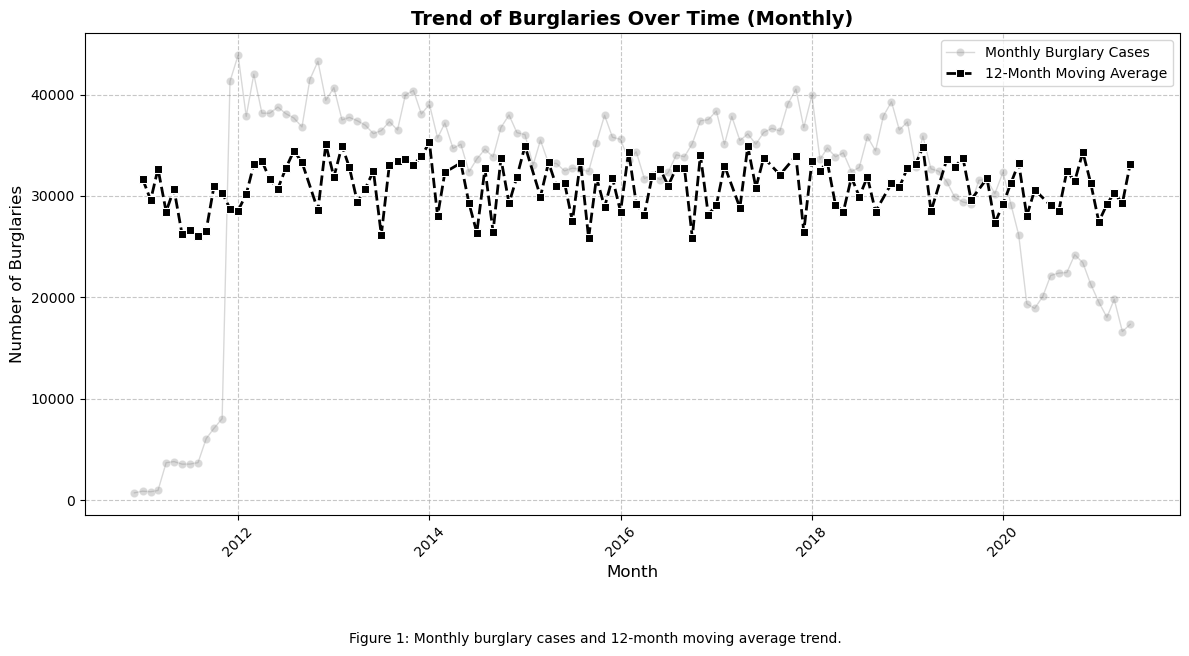

In [20]:
# --------------------------
# 0. Convert Updated PySpark DataFrames to Pandas
# --------------------------
city_burglary_rates_pd = city_burglary_rates_by_rate.toPandas()
burglary_trend_pd = burglary_trendDF.toPandas()
birmingham_vs_national_pd = burglary_comparison.toPandas()
firearm_trend_pd = firearm_trendDF.toPandas()
drug_trend_pd = drug_trendDF.toPandas()

# --------------------------
# 1. Burglary Trends Over Time (Monthly) (Figure 1)
# --------------------------
# Create a 12-month rolling average
burglary_monthly_pd['rolling_avg'] = burglary_monthly_pd['total_burglaries'].rolling(window=12).mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='total_burglaries', data=burglary_monthly_pd, marker='o', color='grey', linewidth=1, alpha=0.3, label='Monthly Burglary Cases')
sns.lineplot(x='date', y='rolling_avg', data=burglary_monthly_pd, marker='s', color='black', linewidth=2, linestyle='dashed', label='12-Month Moving Average')
plt.title('Trend of Burglaries Over Time (Monthly)', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Burglaries', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Add Figure1 Label
plt.figtext(0.5, -0.08, "Figure 1: Monthly burglary cases and 12-month moving average trend.", 
            wrap=True, horizontalalignment='center', fontsize=10)

plt.show()

The burglary trend shows a sharp rise in the early 2010s, likely due to improved crime reporting and data collection, followed by relative stability and a slight decline after 2013.

__Reasoning:__ The line chart *(Figure 1)* shows that burglary incidents did not continually increase year-on-year. Instead, after an initial spike around 2012–2013, the burglary count stabilises and then declines toward 2020. This suggests that, contrary to the claim, burglaries are not currently on an upward trajectory and were not in 2018 when the claim was made. This finding also aligns with official crime statistics, which report long-term declines in burglary rates over the last two decades [7].

We begin to conclude that the data __does not support the first claim__ (“Burglary crime is increasing”).


## City-Level Burglary Rates (Birmingham vs UK)
Next, to examine whether Birmingham has more burglaries per head than anywhere else, the number of burglaries per 1,000 residents was calculated and compared against other cities and the national average. The burglary data was joined with the *‘LSOA_pop’* dataset to calculate the per-capita population figures for each local authority in the UK [7].

This is vital to this report, as Birmingham’s raw crime count is expected to be high. As a major metropolitan area, Birmingham's per capita rate provides a fairer comparison across cities of different sizes [1]. 

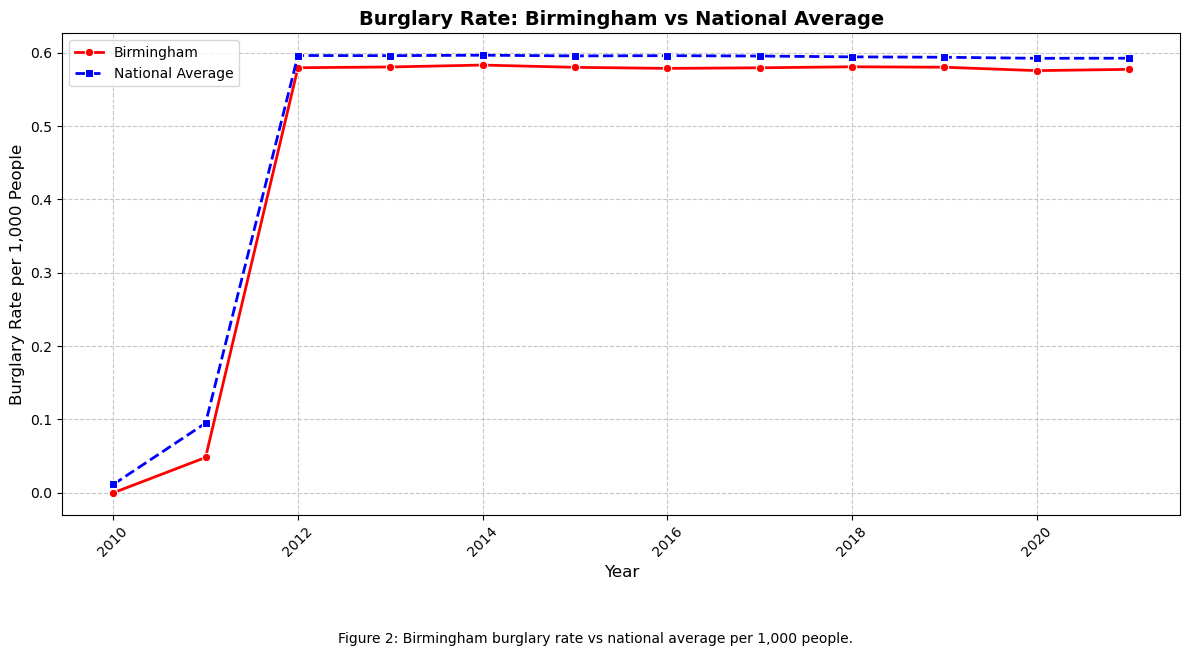

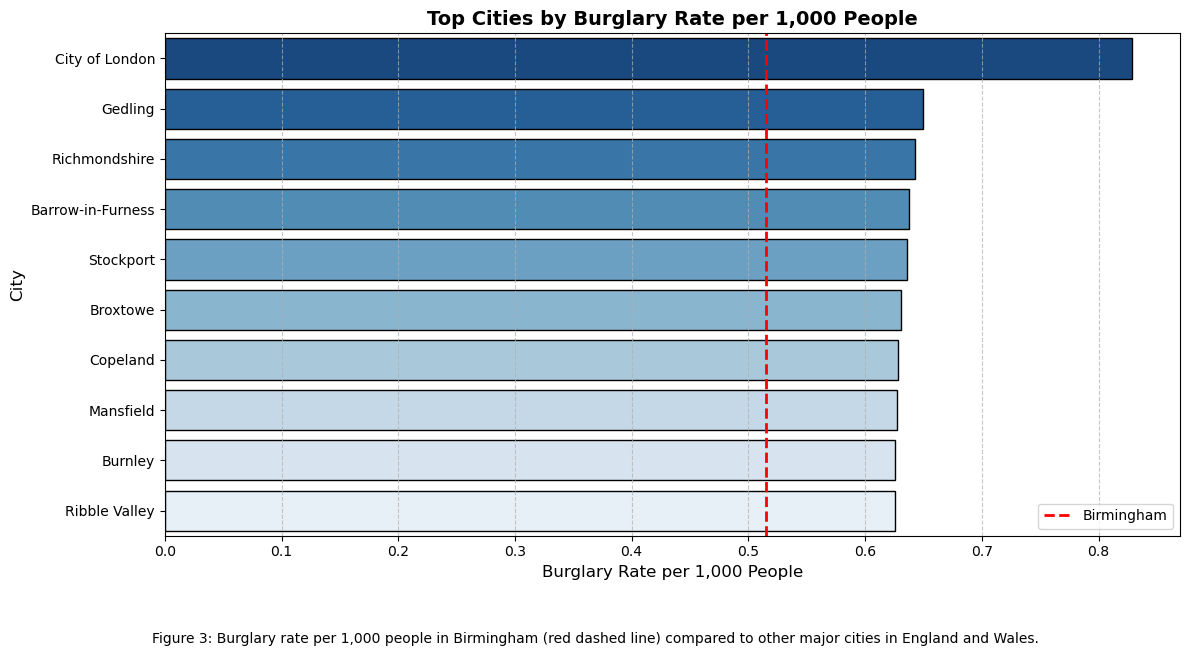

In [19]:
# --------------------------
# 2. Birmingham vs National Burglary Rates (Yearly) (Figure 2)
# --------------------------
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='birmingham_burglary_rate', data=birmingham_vs_national_pd, marker='o', color='red', linewidth=2, label='Birmingham')
sns.lineplot(x='year', y='national_burglary_rate', data=birmingham_vs_national_pd, marker='s', color='blue', linewidth=2, linestyle='dashed', label='National Average')
plt.title('Burglary Rate: Birmingham vs National Average', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Burglary Rate per 1,000 People', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Add Figure2 Label
plt.figtext(0.5, -0.08, "Figure 2: Birmingham burglary rate vs national average per 1,000 people.", 
            wrap=True, horizontalalignment='center', fontsize=10)

plt.show()

# --------------------------
# 3. Top Cities by Burglary Rate
# --------------------------

# Ensure major cities are included in the dataset
top_cities = city_burglary_rates_pd.sort_values(by='burglary_rate_per_1000', ascending=False).head(10)

if "City of London" not in top_cities['city'].values:
    city_of_london_row = city_burglary_rates_pd[city_burglary_rates_pd['city'] == "City of London"]
    if not city_of_london_row.empty:
        top_cities = pd.concat([top_cities, city_of_london_row])

plt.figure(figsize=(12, 6))
sns.barplot(x='burglary_rate_per_1000', y='city', data=top_cities, palette='Blues_r', edgecolor='black')

# Highlight Birmingham
birmingham_rate = city_burglary_rates_pd[city_burglary_rates_pd['city'] == 'Birmingham']['burglary_rate_per_1000'].values
if len(birmingham_rate) > 0:
    plt.axvline(x=birmingham_rate[0], color='red', linestyle='--', linewidth=2, label='Birmingham')

plt.title('Top Cities by Burglary Rate per 1,000 People', fontsize=14, fontweight='bold')
plt.xlabel('Burglary Rate per 1,000 People', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add Figure3 Label
plt.figtext(0.5, -0.08, "Figure 3: Burglary rate per 1,000 people in Birmingham (red dashed line) compared to other major cities in England and Wales.",
            wrap=True, horizontalalignment='center', fontsize=10)
plt.show()


__Reasoning:__ As seen above, the calculated burglary rates reveal that Birmingham’s rate is not the highest in the country. In our data, Birmingham’s burglary incidence per 1,000 residents is very close to the overall national average, as illustrated in *Figure 2*. Other cities, including the City of London and Gelding, had a higher burglary rate per capita than Birmingham (as indicated in *Figure 3*). Thus, the claim that Birmingham has more burglaries per head than anywhere else is false. 

Birmingham does experience a lot of burglaries. However, it is a major city, and this is to be expected. When distributed on a per-capita basis, we can see that it is not among the cities with the highest burglary rates in the UK. This illustrates the importance of the per-capita metric in crime comparisons [10].

## Association between Firearm and Drug Offences
To investigate this claim, we analysed the geographic co-occurrence of both drug offences and firearm crimes. This report defined firearm-related crimes as offences in the possession of weapons category that resulted in either a prison sentence or a Crown Court appearance. This definition aligns with UK Home Office reporting [8] and Ratcliffe’s framework [1], which emphasises focusing on high-severity crimes when assessing serious criminal behaviour.This targeted serious weapon incidents where firearms were likely involved.

To understand regional crime distribution, offences for both variables were tallied by area using Lower Super Output Areas (LSOA). A dual-axis line was used to visualise trends in drug and firearm crimes over time. Later, a formal statistical test *(Pearson correlation)* was performed to evaluate the relationship association formally.	

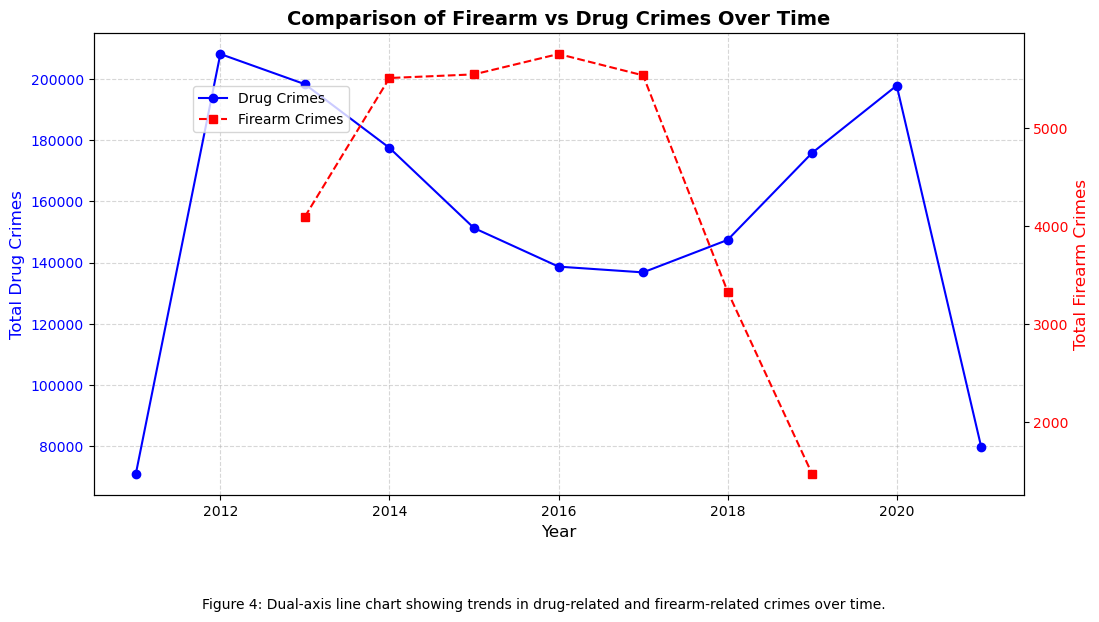

In [21]:
# --------------------------
# 4. Firearm vs. Drug Crimes Over Time (Dual Axis)
# --------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary Y-Axis: Drug Crimes
ax1.plot(drug_trend_pd["year"], drug_trend_pd["total_drug_crimes"], color="blue", marker="o", label="Drug Crimes")
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Total Drug Crimes", fontsize=12, color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Secondary Y-Axis: Firearm Crimes
ax2 = ax1.twinx()
ax2.plot(firearm_trend_pd["year"], firearm_trend_pd["total_firearm_crimes"], color="red", marker="s", linestyle="--", label="Firearm Crimes")
ax2.set_ylabel("Total Firearm Crimes", fontsize=12, color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Fixing Legend for Dual Axis
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.title("Comparison of Firearm vs Drug Crimes Over Time", fontsize=14, fontweight="bold")
ax1.grid(True, linestyle="--", alpha=0.5)

# Add Figure4 Label
plt.figtext(0.5, -0.08, "Figure 4: Dual-axis line chart showing trends in drug-related and firearm-related crimes over time.",
            wrap=True, horizontalalignment='center', fontsize=10)

plt.show()


__Reasoning:__
Drug offences peaked in 2012, declining until 2017, with a modest rise afterwards. Firearm offences, specifically filtered weapon possession crimes, rose from 2013 to 2016, then dropped sharply post-2017. There was a notable spike in both firearm incidents and heightened drug crime, partially supporting the documentary’s claim. 

*Figure 4* also shows the divergence between the variables after 2017, indicating that the relationship between the trends varies over time. We must state here that co-occurrence does not imply causation [9]. **Further statistical analysis should be performed to examine the relationship between these two variables before deciding on whether we should accept the documentary’s claim.**

## 5) Selection, application, and reasoning behind use of statistical analysis and multiple evaluation measures  

## Statistical Analysis Implementation  

### 1. T-Test: Burglary Rate Change Over Time  

In [22]:
# --------------------------
# 1. T-Test: Burglary Rate Change (Early vs. Recent Years)
# --------------------------
early_years = burglary_trend_pd[burglary_trend_pd['year'] <= 2015]['total_burglaries']
recent_years = burglary_trend_pd[burglary_trend_pd['year'] > 2015]['total_burglaries']

t_stat, p_value = ttest_ind(early_years, recent_years, equal_var=False)
print(f"T-Test for Burglary Rate Change:")
print(f"T-Statistic: {t_stat:.3f}, P-Value: {p_value:.5f}")
print("Statistically Significant Increase in Burglary Crimes" if p_value < 0.05 else "No Strong Evidence for Increase.")

T-Test for Burglary Rate Change:
T-Statistic: -0.302, P-Value: 0.77027
No Strong Evidence for Increase.


A t-test comparing early and late periods within the data **(before and after 2015)** was used to analyse whether burglary rates changed over time. This statistical test is appropriate for comparing the means of two time periods to assess whether observed differences are likely to have occurred by chance [9]. The test resulted in a **T-statistic of -0.302** and a **P-value of 0.77027**, indicating **no statistically significant evidence** of an increase or decrease. 

Taking the high P-value alone, it is clear that we cannot conclude that the changes in burglary rates are anything more than a natural variation. This finding aligns with official UK government crime statistics [7], which suggest a long-term decline in burglary rates but short-term fluctuations in trends.

### 2. T-Test: Birmingham vs National Burglary Rate

In [23]:
# --------------------------
# 2 T-Test: Birmingham vs National Burglary Rate
# --------------------------
birmingham_rates = birmingham_vs_national_pd["birmingham_burglary_rate"]
national_rates = birmingham_vs_national_pd["national_burglary_rate"]

t_stat, p_value = ttest_ind(birmingham_rates, national_rates, equal_var=False)
print(f"\nT-Test: Birmingham vs National Burglary Rate")
print(f"T-Statistic: {t_stat:.3f}, P-Value: {p_value:.5f}")
print("Birmingham has a significantly higher burglary rate" if p_value < 0.05 else "No strong difference detected.")


T-Test: Birmingham vs National Burglary Rate
T-Statistic: -0.202, P-Value: 0.84185
No strong difference detected.


To further investigate if Birmingham has the highest burglary rate in the UK, we compared it against the national average via a t-test. This test resulted in a **t-statistic of -0.202** and a **P-value of 0.84185**, meaning Birmingham’s burglary rate is **not statistically different from the national average** [6]. 
As outlined earlier in *Figure 2*, direct comparison to other UK cities shows other cities top the list of most burglaries, further disproving the claim that Birmingham has the highest burglary rate.

## 3. Drug and Firearm Crime Correlation

In [24]:
# --------------------------
# 3. Pearson Correlation Between Firearm & Drug Crimes
# --------------------------
common_years = firearm_trend_pd.merge(drug_trend_pd, on="year")
correlation, p_value = pearsonr(common_years["total_firearm_crimes"], common_years["total_drug_crimes"])
print(f"\nPearson Correlation between firearm and Drug Crimes: {correlation:.3f}, P-Value: {p_value:.5f}")


Pearson Correlation between firearm and Drug Crimes: -0.406, P-Value: 0.36656


In [25]:
# Suppress unnecessary warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    warnings.simplefilter("ignore", category=Warning)
# --------------------------
# 4. Linear Regression: Drug Crimes Predicting Firearm Crimes
# --------------------------

    X = sm.add_constant(common_years["total_drug_crimes"])
    Y = common_years["total_firearm_crimes"]
    model = sm.OLS(Y, X).fit()
    print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     total_firearm_crimes   R-squared:                       0.165
Model:                              OLS   Adj. R-squared:                 -0.003
Method:                   Least Squares   F-statistic:                    0.9849
Date:                  Wed, 26 Mar 2025   Prob (F-statistic):              0.367
Time:                          21:12:17   Log-Likelihood:                -60.434
No. Observations:                     7   AIC:                             124.9
Df Residuals:                         5   BIC:                             124.8
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             

A Pearson correlation test was performed to determine whether drug and firearm crimes were statistically associated with local areas. Pearson's "R" is commonly used to assess the strength and direction of linear relationships between two continuous variables in observational data [9]. The result was a **correlation coefficient of -0.406** and a **P-value of 0.36656**, indicating a **weak and statistically insignificant relationship**. This suggests that higher drug crime rates are not reliably linked to higher firearm offences across the LSOAs. 

As our visualisation investigation was inconclusive, linear regression was added to the statistical analysis section to bolster conclusions further. A linear regression was then conducted to examine whether drug crimes could predict firearm incidents. The result was a **R-squared value of 0.165**. This means that drug crimes explain only 17% of the variation in firearm crimes. The model’s **P-value of 0.367** confirms the **non-statistically significant relationship between the variables** [6].

## 6.) Discussion of Appropriateness

### Discussion of Appropriateness

The methods employed in this report are broadly consistent with the study’s objectives, with advantages and limitations noted here. 

**Apache Spark** was chosen to handle approximately 19 million records due to its distributed computing. This tool effectively filtered and aggregated the datasets, unlike more straightforward tools such as Pandas, which risk memory overflow [5]. Using Spark on a cloud platform (Azure IaaS) allowed for scalable workflows.

The filtering stage effectively separated the data to show burglary, drug offences and weapon-related crimes, but a key limitation in using the *Possession of Weapons* categories to infer “firearm incidents” as we are assuming that a strong sentence such as a prison sentence implies that the weapon was a gun [7]. Ideally, **firearm-specific data** would enhance analysis precision. Our method might over-or-under count actual firearm offences. However, as it captures severe cases, it will indicate broader patterns.

Using **per-capita rates** to compare burglary rates between Birmingham and other cities was vital since raw counts can be misleading compared to smaller towns [6]. Normalising counts per 1,000 residents using the population data from the *lsoa_pop dataset (derived from the English Indices of Deprivation 2010*) resulted in fair comparisons, though the older dataset may affect precision. It is recommended that future analyses use more up-to-date datasets. Overall, the population problem from 2010 data should not significantly impact ranking, ensuring robust conclusions.

The **visualisation section** of our analysis effectively communicated key findings; the burglary trend line highlighted changes over time, and the Birmingham vs National burglary chart indicated Birmingham was not an outlier. Using a dual-axis line chart to compare firearm offences and drug crime allowed for simultaneous tracking of both variables, making it easier to notice any movement in the patterns of the variables. While no strong correlation was observed, the chart supported the statistical conclusion of a weak correlation. In future, **error bars or confidence intervals** could improve interpretation in future iterations, but using complete population data made their omission acceptable. 

While our datasets **only cover England and Wales**, the claim that Birmingham’s burglary rate is assumed to apply to the UK overall, though the data excludes Scotland and Northern Ireland. This report believes that the **data quality** is high enough to state that the omission of these data points is unlikely to affect Birmingham’s rankings significantly.

A significant limitation of our study was our analysis was **observational**. Testing for a statistical association between drug and firearm crimes yielded a weak Pearson correlation of -0.406 (p=0.36656), indicating no conclusive link. The linear regression model suggested a lack of predictive relationships (R² = 0.165, p = 0.367), challenging previous assumptions relating to the relationship of these two variables. This is likely due to the data selection, as **socio-economic factors** were not included to create a more nuanced look at this measure due to the limited scope of this project. Future versions could adapt this approach to improve the quality of conclusions.

Similarly, the **burglary trend analysis** revealed no significant long-term increase or decrease (T-statistic = -0.302, P-Value: 0.77027), suggesting that these findings may lack robustness and could be influenced by natural fluctuations in the data rather than a true underlying trend [9].


## 7. Evaluation and Conclusion 

**Claim 1 – “Burglaries are increasing” (as of 2018)**

The evidence in this analysis does not support this claim, considering that it was made in 2018. While there were fluctuations in earlier years, no sustained increase led up to 2018. The burglary trend peaked in 2013 and declined thereafter. Although shorter-term variations exist, a t-test for burglary rate change yielded a t-statistic of 0.316 and a p-value of 0.7599, indicating no statistically significant difference over the years.
Furthermore, data from the Office for National Statistics (ONS) confirms that the burglary trend has broadly been declining across England and Wales, with a 71% decline between 2003 and 2024 [7]. By 2018, burglary rates had not returned to their previous heights, making it unlikely the claim was valid when it was made.

__Verdict: FALSE__


__Claim 2 – “More burglaries per head in Birmingham than anywhere else” (as of 2018)__

The data also does not support this claim. The population-adjusted analysis of burglary rates used here indicates that Birmingham had a high absolute number of burglaries. Still, its per-capita rate was not the highest among English and Welsh cities.

Since the claim states that Birmingham has the highest of all UK cities, it was only necessary to find at least one other city with a higher per-capita burglary rate to debunk the claim. Cities such as London, Gelding and Burnley all had higher per-capita rates, resulting in the ability of this report to disprove the claim. 
The t-test comparing Birmingham’s burglary rate to the national average resulted in a t-statistic of-0.202 and a p-value of 0.84185, suggesting no significant difference. This means that while Birmingham had a high volume of burglaries due to its high population size, it did not turn out as the most burglary-prone city per capita. 

__Verdict: FALSE__

**Claim 3 – “Firearms incidents are closely associated with drug offences” (as of 2018)**
Our findings do not strongly support the claim based on available data up to 2018. While most literature and convention would state that there is a link between drug and firearm crimes, the Pearson correlation coefficient between drug and firearm incidents is -0.406 (p = 0.36656), indicating no statistically significant association.

Additionally, our linear regression model did not find any predictive relationship between drug crime levels and firearm incidents, with an R-squared value of just 0.165 and a p-value of 0.367, meaning the association between the variables is weak and not statistically significant [9]. This contradicts the claim that drug and firearm incidents are “closely associated” in a meaningful way. It is not denied that some anecdotal or localised evidence suggests a connection; our data-driven approach does not confirm this claim at a statistically significant level. 

__Verdict: Not supported.__

As Ridgeway (2018) notes, while Big Data systems are now widespread, the true challenge is in translating raw data into actionable knowledge that improves public safety. This project demonstrates how open datasets and statistical tools in Python can support such efforts [11].
In conclusion, this study found that the available data supported none of the three claims made and are, therefore, not accepted. This highlights the value of a data-driven evaluation in challenging public narratives [1]. Building an end-to-end pipeline using spark, Pandas and cloud infrastructure allowed for a quality analysis that handled large-scale crime data effectively. Future versions of this research would benefit from incorporating higher geographic and socioeconomic factors, offering more profound insights into crime patterns.!

## 8) Style and Referencing 

[1] J. Ratcliffe, *Intelligence-Led Policing*, 2nd ed. London, UK: Routledge, 2016.

[2] data.police.uk, “Street-level crimes,” [Online]. Available: https://data.police.uk/docs/method/crime-street/. [Accessed: 02-Mar-2025].

[3] data.gov.uk, “Street level crime (police.uk data),” [Online]. Available: https://www.data.gov.uk/dataset/bb2c3b16-6719-4e00-ae75-48dd462cb915/england-national-crime-mapping. [Accessed: 02-Mar-2025].

[4] data.police.uk, “Data downloads,” [Online]. Available: https://data.police.uk/data/. [Accessed: 02-Mar-2025].

[5] Q. Q. Tran, D.-B. Nguyen, L. T. T. Nguyen, and O. T. T. Nguyen, “Big Data Processing with Apache Spark,” *The Scientific Journal of Tra Vinh University*, vol. 13, no. 6, Jul. 2023. [Online]. Available: https://www.researchgate.net/publication/375732310_BIG_DATA_PROCESSING_WITH_APACHE_SPARK. [Accessed: 16-Mar-2025].

[6] J. VanderPlas, *Python Data Science Handbook: Essential Tools for Working with Data*, 2nd ed. Sebastopol, CA: O’Reilly Media, 2023.

[7] Office for National Statistics, “Crime in England and Wales: year ending June 2024,” 27-Jun-2024. [Online]. Available: https://www.ons.gov.uk/peoplepopulationandcommunity/crimeandjustice/bulletins/crimeinenglandandwales/yearendingjune2024. [Accessed: 02-Mar-2025].

[8] Home Office, “Crime outcomes in England and Wales 2022 to 2023,” 20-Jul-2023. [Online]. Available: https://www.gov.uk/government/statistics/crime-outcomes-in-england-and-wales-2022-to-2023. [Accessed: 05-Mar-2025].

[9] A. Field, *Discovering Statistics Using Python*, 1st ed. London, UK: Sage Publications, 2017.

[10] A. Crawford, "Crime prevention and community safety," in *Handbook of Policing*, 2nd ed., T. Newburn, Ed. London: Routledge, 2008, pp. 876–913.

[11] G. Ridgeway, "Policing in the Era of Big Data," *Annual Review of Criminology*, vol. 1, pp. 401–419, 2018. [Online]. Available: https://doi.org/10.1146/annurev-criminol-062217-114209. [Accessed: 22-Mar-2025].